In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import cv2
import PIL
import PIL.Image
import matplotlib.pyplot as plt


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [ ]:
# import MobileNet
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

#TODO: This dataset is actually RAF-DB insteal of AffectNet!!!
train_path = '/content/drive/My Drive/CS6476/RAFDB/DATASET/train'
val_path = '/content/drive/My Drive/CS6476/RAFDB/DATASET/val'
test_path = '/content/drive/My Drive/CS6476/RAFDB/DATASET/test'

In [ ]:
# preprocess training data using ImageDataGenerator
train_data = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=64,
    color_mode='rgb',
    class_mode='categorical'
    )

val_data = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=64,color_mode='rgb',class_mode='categorical')

test_data = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=64,color_mode='rgb',class_mode='categorical',
    shuffle=False
)


Found 9814 images belonging to 7 classes.
Found 2457 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.


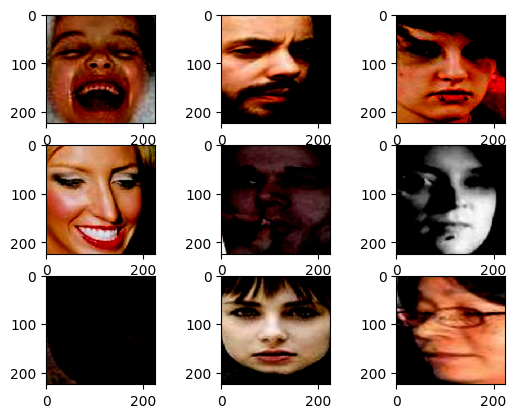

In [ ]:
img, label = train_data.next()
# visualize img in grid
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(img[i])
plt.show()

In [ ]:
# load trained model
model = keras.models.load_model('/content/drive/MyDrive/CS6476/training_1/MobileNet-epoch20-batch64.keras')

In [ ]:
# load MobileNet model summary
model = MobileNet()
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

# **Finetuning MobileNet for FER**

In [ ]:
# freeze all layers in mobile net except for the last layer

for layer in model.layers[:-3]:
    layer.trainable = False


In [ ]:
# prompt: add a linear layer on the end of the model that outputs 7 logits by using a sequential wrapper

model = keras.Sequential([
    model,
    keras.layers.Dense(7, activation='softmax')
])


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

4

In [ ]:
checkpoint_path = "/content/drive/MyDrive/CS6476/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor = 'val_accuracy',
                                                 mode='max',
                                                 save_best_only=True,
                                                 verbose=1)

In [ ]:
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

In [ ]:
history = model.fit(train_data, epochs=20, validation_data=val_data, callbacks=[cp_callback, reduce_lr_callback])


Epoch 1/20
154/154 [==============================] - ETA: 0s - loss: 1.8361 - accuracy: 0.3868
Epoch 1: val_accuracy improved from -inf to 0.38869, saving model to /content/drive/MyDrive/CS6476/training_1/cp.ckpt
154/154 [==============================] - 69s 431ms/step - loss: 1.8361 - accuracy: 0.3868 - val_loss: 1.7577 - val_accuracy: 0.3887 - lr: 0.0010
Epoch 2/20
154/154 [==============================] - ETA: 0s - loss: 1.6800 - accuracy: 0.3908
Epoch 2: val_accuracy improved from 0.38869 to 0.42857, saving model to /content/drive/MyDrive/CS6476/training_1/cp.ckpt
154/154 [==============================] - 66s 430ms/step - loss: 1.6800 - accuracy: 0.3908 - val_loss: 1.6154 - val_accuracy: 0.4286 - lr: 0.0010
Epoch 3/20
154/154 [==============================] - ETA: 0s - loss: 1.5569 - accuracy: 0.4886
Epoch 3: val_accuracy improved from 0.42857 to 0.51974, saving model to /content/drive/MyDrive/CS6476/training_1/cp.ckpt
154/154 [==============================] - 67s 433ms/step 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('/content/drive/MyDrive/CS6476/training_1/MobileNet-epoch20-batch64.keras')

In [ ]:
model.evaluate(test_data, verbose=1)

48/48 [==============================] - 16s 318ms/step - loss: 1.0451 - accuracy: 0.6607


[1.0450938940048218, 0.6606910228729248]

In [ ]:

training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
val_loss = history.history['val_loss']

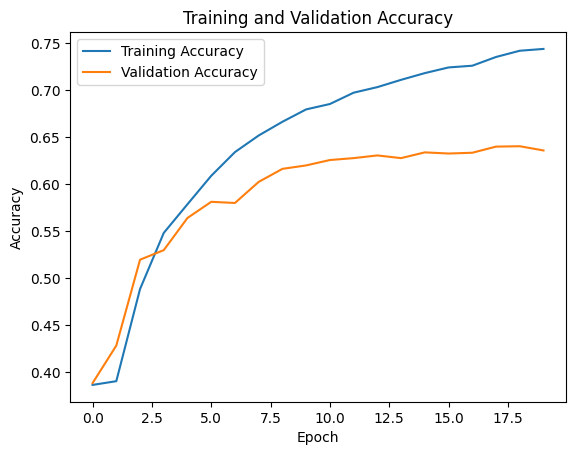

In [ ]:
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

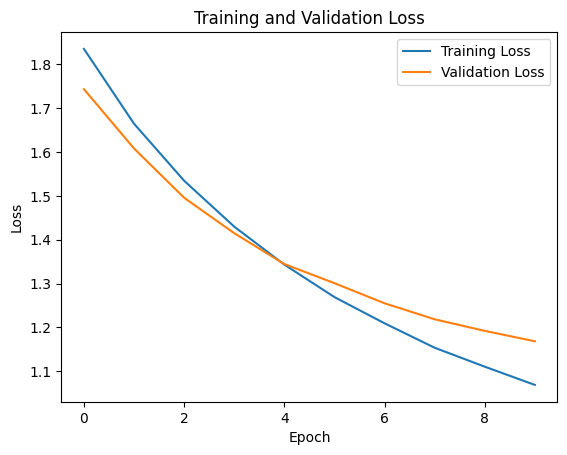

In [ ]:
plt.plot(training_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()